In [7]:
import numpy as np
from numpy import linalg as LA
import random

# LOADING POLYNOMIALS USING MPS

This set of functions are taken from Maria Cea Fernández

In [8]:
import numpy as np
from numpy import linalg as LA
import random

In [9]:
# ncon network contractor
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2020

# ncon.py
import numpy as np
from typing import List, Union, Tuple, Optional


def ncon(tensors: List[np.ndarray],
         connects: List[Union[List[int], Tuple[int]]],
         con_order: Optional[Union[List[int], str]] = None,
         check_network: Optional[bool] = True,
         which_env: Optional[int] = 0):
  """
  Network CONtractor: contracts a tensor network of N tensors via a sequence
  of (N-1) tensordot operations. More detailed instructions and examples can
  be found at: https://arxiv.org/abs/1402.0939.
  Args:
    tensors: list of the tensors in the network.
    connects: length-N list of lists (or tuples) specifying the network
      connections. The jth entry of the ith list in connects labels the edge
      connected to the jth index of the ith tensor. Labels should be positive
      integers for internal indices and negative integers for free indices.
    con_order: optional argument to specify the order for contracting the
      positive indices. Defaults to ascending order if omitted. Can also be
      set at "greedy" or "full" to call a solver to automatically determine
      the order.
    check_network: if true then the input network is checked for consistency;
      this can catch many common user mistakes for defining networks.
    which_env: if provided, ncon will produce the environment of the requested
      tensor (i.e. the network given by removing the specified tensor from
      the original network). Only valid for networks with no open indices.
  Returns:
    Union[np.ndarray,float]: the result of the network contraction; an
      np.ndarray if the network contained open indices, otherwise a scalar.
  """
  num_tensors = len(tensors)
  tensor_list = [tensors[ele] for ele in range(num_tensors)]
  connect_list = [np.array(connects[ele]) for ele in range(num_tensors)]

  # generate contraction order if necessary
  flat_connect = np.concatenate(connect_list)
  if con_order is None:
    con_order = np.unique(flat_connect[flat_connect > 0])
  else:
    con_order = np.array(con_order)

  # check inputs if enabled
  if check_network:
    dims_list = [list(tensor.shape) for tensor in tensor_list]
    check_inputs(connect_list, flat_connect, dims_list, con_order)

  # do all partial traces
  for ele in range(len(tensor_list)):
    num_cont = len(connect_list[ele]) - len(np.unique(connect_list[ele]))
    if num_cont > 0:
      tensor_list[ele], connect_list[ele], cont_ind = partial_trace(
          tensor_list[ele], connect_list[ele])
      con_order = np.delete(
          con_order,
          np.intersect1d(con_order, cont_ind, return_indices=True)[1])

  # do all binary contractions
  while len(con_order) > 0:
    # identify tensors to be contracted
    cont_ind = con_order[0]
    locs = [
        ele for ele in range(len(connect_list))
        if sum(connect_list[ele] == cont_ind) > 0
    ]

    # do binary contraction
    cont_many, A_cont, B_cont = np.intersect1d(
        connect_list[locs[0]],
        connect_list[locs[1]],
        assume_unique=True,
        return_indices=True)
    if np.size(tensor_list[locs[0]]) < np.size(tensor_list[locs[1]]):
      ind_order = np.argsort(A_cont)
    else:
      ind_order = np.argsort(B_cont)

    tensor_list.append(
        np.tensordot(
            tensor_list[locs[0]],
            tensor_list[locs[1]],
            axes=(A_cont[ind_order], B_cont[ind_order])))
    connect_list.append(
        np.append(
            np.delete(connect_list[locs[0]], A_cont),
            np.delete(connect_list[locs[1]], B_cont)))

    # remove contracted tensors from list and update con_order
    del tensor_list[locs[1]]
    del tensor_list[locs[0]]
    del connect_list[locs[1]]
    del connect_list[locs[0]]
    con_order = np.delete(
        con_order,
        np.intersect1d(con_order, cont_many, return_indices=True)[1])

  # do all outer products
  while len(tensor_list) > 1:
    s1 = tensor_list[-2].shape
    s2 = tensor_list[-1].shape
    tensor_list[-2] = np.outer(tensor_list[-2].reshape(np.prod(s1)),
                               tensor_list[-1].reshape(np.prod(s2))).reshape(
                                   np.append(s1, s2))
    connect_list[-2] = np.append(connect_list[-2], connect_list[-1])
    del tensor_list[-1]
    del connect_list[-1]

  # do final permutation
  if len(connect_list[0]) > 0:
    return np.transpose(tensor_list[0], np.argsort(-connect_list[0]))
  else:
    return tensor_list[0].item()


def partial_trace(A, A_label):
  """ Partial trace on tensor A over repeated labels in A_label """

  num_cont = len(A_label) - len(np.unique(A_label))
  if num_cont > 0:
    dup_list = []
    for ele in np.unique(A_label):
      if sum(A_label == ele) > 1:
        dup_list.append([np.where(A_label == ele)[0]])

    cont_ind = np.array(dup_list).reshape(2 * num_cont, order='F')
    free_ind = np.delete(np.arange(len(A_label)), cont_ind)

    cont_dim = np.prod(np.array(A.shape)[cont_ind[:num_cont]])
    free_dim = np.array(A.shape)[free_ind]

    B_label = np.delete(A_label, cont_ind)
    cont_label = np.unique(A_label[cont_ind])
    B = np.zeros(np.prod(free_dim))
    A = A.transpose(np.append(free_ind, cont_ind)).reshape(
        np.prod(free_dim), cont_dim, cont_dim)
    for ip in range(cont_dim):
      B = B + A[:, ip, ip]

    return B.reshape(free_dim), B_label, cont_label

  else:
    return A, A_label, []


def check_inputs(connect_list, flat_connect, dims_list, con_order):
  """ Check consistancy of NCON inputs"""

  pos_ind = flat_connect[flat_connect > 0]
  neg_ind = flat_connect[flat_connect < 0]

  # check that lengths of lists match
  if len(dims_list) != len(connect_list):
    raise ValueError(
        ('mismatch between %i tensors given but %i index sublists given') %
        (len(dims_list), len(connect_list)))

  # check that tensors have the right number of indices
  for ele in range(len(dims_list)):
    if len(dims_list[ele]) != len(connect_list[ele]):
      raise ValueError((
          'number of indices does not match number of labels on tensor %i: '
          '%i-indices versus %i-labels')
          % (ele, len(dims_list[ele]), len(connect_list[ele])))

  # check that contraction order is valid
  if not np.array_equal(np.sort(con_order), np.unique(pos_ind)):
    raise ValueError(('NCON error: invalid contraction order'))

  # check that negative indices are valid
  for ind in np.arange(-1, -len(neg_ind) - 1, -1):
    if sum(neg_ind == ind) == 0:
      raise ValueError(('NCON error: no index labelled %i') % (ind))
    elif sum(neg_ind == ind) > 1:
      raise ValueError(('NCON error: more than one index labelled %i') % (ind))

  # check that positive indices are valid and contracted tensor dimensions match
  flat_dims = np.array([item for sublist in dims_list for item in sublist])
  for ind in np.unique(pos_ind):
    if sum(pos_ind == ind) == 1:
      raise ValueError(('NCON error: only one index labelled %i') % (ind))
    elif sum(pos_ind == ind) > 2:
      raise ValueError(
          ('NCON error: more than two indices labelled %i') % (ind))

    cont_dims = flat_dims[flat_connect == ind]
    if cont_dims[0] != cont_dims[1]:
      raise ValueError(
          ('NCON error: tensor dimension mismatch on index labelled %i: '
           'dim-%i versus dim-%i') % (ind, cont_dims[0], cont_dims[1]))

  return True

In [10]:
# The 'MPS' function returns the MPS of a normalized state
# L is the number of sites
# d is the space dimension of each site
# chi is the maximum bond dimension
def MPS(state, L, d, chi):
    MPS = []
    for i in range(L - 1):
        if i == 0:
            U, S, V = LA.svd(state.reshape(d, d**(L-1)),full_matrices=False)
            chil = 1; chir = len(S) 
            if chi < chir:
                S = np.diag(S[range(chi)] / LA.norm(S[range(chi)]))
                U = U[:,range(chi)]
                V = V[range(chi),:]
                chir = chi
            else:
                S = np.diag(S)
            MPS.append(U.reshape(chil, d, chir))
            state = ncon([S, V],[[-1,1],[1,-2]])
        else:
            U, S, V = LA.svd(state.reshape(state.shape[0]*d, state.shape[1]//d),full_matrices=False)
            chir = len(S)
            if chi < chir:
                S = np.diag(S[range(chi)] / LA.norm(S[range(chi)]))
                U = U[:,range(chi)]
                V = V[range(chi),:]  
                chir = chi
            else:
                S = np.diag(S)
            dimU = np.prod(U.shape)
            chil = dimU // (d * len(S)); 
            MPS.append(U.reshape(chil, d, chir))
            state = ncon([S, V],[[-1,1],[1,-2]])
    dimstate = np.prod(state.shape)
    chil = dimstate // d ; chir = 1
    MPS.append(state.reshape(chil, d, chir))
    return MPS

# The 'MPS_contraction' function contracts the tensors 
#forming an MPS to the original state. 
#It is used to check the fidelity of the MPS.
def MPS_contraction(MPS, L, d):
    contraction = MPS[0]
    for i in range(L - 1):
        contraction = ncon([contraction, MPS[i + 1]],[[-1,-2,1],[1,-3,-4]]).reshape(contraction.shape[0], d ** (i + 2), MPS[i + 1].shape[2])
    return contraction[0]

# The 'random_state' function returns a random normalized 
# state given the values of L which is like the number of qubits and d
def random_state(L, d):
    state = []; norm = 0
    for l in range(d ** L):
        random_number = random.random()
        norm += random_number ** 2
        state.append(random_number)
    return np.array([l / np.sqrt(norm) for l in state])

Check how it works for a random tensor

In [11]:
# Let's check how it works for the case of L = 10 and d = 2.
L = 10; d = 2; chis = [2,4,8,16,32]
# With bound dimension arriving to chi=d^(N/2) you are not compressing anything
# In this case is 2^5=32
state = random_state(L, d)
print(state)
for chi in chis:
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fidelity = np.abs(state @ approx_state)**2
    print('Fidelity for chi = '+str(chi)+': ', fidelity[0])

[0.02092726 0.00678997 0.02526346 ... 0.02478299 0.04285332 0.04458343]
Fidelity for chi = 2:  0.7577199710306088
Fidelity for chi = 4:  0.787892256270723
Fidelity for chi = 8:  0.862782093707787
Fidelity for chi = 16:  0.9731635390741711
Fidelity for chi = 32:  1.0000000000000053


In [64]:
chi=1; d=2; L=3
state = random_state(L, d)
mps=MPS(state, L, d, chi)
approx_state = MPS_contraction(mps, L, d)

print(mps[0][0][1]*mps[1][0][1]*mps[2][0][1])
print(approx_state)

[0.24991089]
[[0.15492422]
 [0.05581598]
 [0.58875343]
 [0.21211565]
 [0.18252897]
 [0.0657614 ]
 [0.69365884]
 [0.24991089]]


In [66]:
print(mps)

[array([[[-0.64710168],
        [-0.76240371]]]), array([[[-0.25447657],
        [-0.96707894]]]), array([[[0.94080365],
        [0.33895204]]])]


In [72]:
len(mps)

3

In [70]:
print(mps[2][0][0])

[0.94080365]


In [71]:
print(2*np.arccos(mps[0][0][0]))
print(2*np.arccos(mps[1][0][0]))
print(2*np.arccos(mps[2][0][0]))

[4.54914608]
[3.65620548]
[0.69160555]


### Linear function state

$|\psi\rangle = \frac{1}{\mathcal{N}}\sum_{i=1}^{2^n} i|i\rangle$

In [12]:
# Function that creates the f(x)=x state in amplitudes
# For qubits d=2
def linear_state(d,qubits):
    dim = d**qubits
    state = []
    norm = 0
    for i in range(dim):
        state.append(i)
        norm += i**2
    return np.array([i/np.sqrt(norm) for i in state])

linear_state(2,4)


array([0.        , 0.02839809, 0.05679618, 0.08519428, 0.11359237,
       0.14199046, 0.17038855, 0.19878664, 0.22718473, 0.25558283,
       0.28398092, 0.31237901, 0.3407771 , 0.36917519, 0.39757328,
       0.42597138])

In [13]:
qubits = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]; d = 2; chis = [1,2,4]
for L in qubits:
    print('NUMBER OF QUBITS =', L)
    state = linear_state(d, L)
    for chi in chis:
        mps = MPS(state, L, d, chi)
        approx_state = MPS_contraction(mps, L, d)
        fidelity = np.abs(state @ approx_state)**2
        print('Fidelity for chi = '+str(chi)+': ', fidelity[0])

NUMBER OF QUBITS = 1
Fidelity for chi = 1:  1.0
Fidelity for chi = 2:  1.0
Fidelity for chi = 4:  1.0
NUMBER OF QUBITS = 2
Fidelity for chi = 1:  0.9791574237499551
Fidelity for chi = 2:  1.0
Fidelity for chi = 4:  1.0
NUMBER OF QUBITS = 3
Fidelity for chi = 1:  0.9828915665604511
Fidelity for chi = 2:  1.0000000000000004
Fidelity for chi = 4:  1.0000000000000004
NUMBER OF QUBITS = 4
Fidelity for chi = 1:  0.9852447189941068
Fidelity for chi = 2:  0.9999999999999998
Fidelity for chi = 4:  0.9999999999999996
NUMBER OF QUBITS = 5
Fidelity for chi = 1:  0.9864349456807145
Fidelity for chi = 2:  0.9999999999999991
Fidelity for chi = 4:  0.9999999999999996
NUMBER OF QUBITS = 6
Fidelity for chi = 1:  0.987025642928207
Fidelity for chi = 2:  1.0000000000000004
Fidelity for chi = 4:  1.0
NUMBER OF QUBITS = 7
Fidelity for chi = 1:  0.9873191356010879
Fidelity for chi = 2:  1.0000000000000013
Fidelity for chi = 4:  1.0000000000000027
NUMBER OF QUBITS = 8
Fidelity for chi = 1:  0.987465335500713


Fidelity for chi = 4:  1.0000000000000022
NUMBER OF QUBITS = 16
Fidelity for chi = 1:  0.9876105730547129
Fidelity for chi = 2:  1.0000000000000004
Fidelity for chi = 4:  1.0
NUMBER OF QUBITS = 17
Fidelity for chi = 1:  0.9876108574368823
Fidelity for chi = 2:  1.0000000000000004
Fidelity for chi = 4:  1.0000000000000004
NUMBER OF QUBITS = 18
Fidelity for chi = 1:  0.987610999627371
Fidelity for chi = 2:  1.0000000000000022
Fidelity for chi = 4:  1.0000000000000009
NUMBER OF QUBITS = 19
Fidelity for chi = 1:  0.9876110707224667
Fidelity for chi = 2:  1.000000000000003
Fidelity for chi = 4:  1.0000000000000022
NUMBER OF QUBITS = 20
Fidelity for chi = 1:  0.9876111062699828
Fidelity for chi = 2:  1.0000000000000013
Fidelity for chi = 4:  1.0000000000000013


In [14]:
d=2; chi=1; L=4
state = linear_state(d, L)
mps = MPS(state, L, d, chi)
approx_state = MPS_contraction(mps, L, d)
fidelity = np.abs(state @ approx_state)**2
print(approx_state)
print(fidelity)
print(state)

[[0.07417961]
 [0.08198506]
 [0.09079722]
 [0.10035123]
 [0.11315503]
 [0.12506161]
 [0.13850385]
 [0.15307773]
 [0.22058418]
 [0.24379485]
 [0.26999913]
 [0.29840941]
 [0.33648343]
 [0.37188943]
 [0.41186194]
 [0.45519955]]
[0.98524472]
[0.         0.02839809 0.05679618 0.08519428 0.11359237 0.14199046
 0.17038855 0.19878664 0.22718473 0.25558283 0.28398092 0.31237901
 0.3407771  0.36917519 0.39757328 0.42597138]


CONCLUSION: for chi=1 very good fidelities and for chi=2 is exact

# MONOMIALS

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
# Function that creates the f(x)=x state in amplitudes
# For qubits d=2
def monomial_state(d,qubits,degree):
    '''
    Given a physical dimension and a number of qubits this function returns you the monomial of a given degree encoded in the 
    amplitudes of a quantum state
    '''
    dim = d**qubits
    state = []
    norm = 0
    for i in range(dim):
        element = i**degree
        state.append(element)
        norm += np.abs(element)**2
    norm = np.sqrt(norm)
    return np.array([i/norm for i in state])

$f(x)=x^3$ for different number of qubits and bond dimensions

In [16]:
qubits = [1,2,3,4,5,6,7,8,9,10]; d = 2; chis = [1,2,4]; degree = 3
for L in qubits:
    print('NUMBER OF QUBITS =', L)
    state = monomial_state(d, L, degree)
    for chi in chis:
        mps = MPS(state, L, d, chi)
        approx_state = MPS_contraction(mps, L, d)
        fidelity = np.abs(state @ approx_state)**2
        print('Fidelity for chi = '+str(chi)+': ', fidelity[0])

NUMBER OF QUBITS = 1
Fidelity for chi = 1:  1.0
Fidelity for chi = 2:  1.0
Fidelity for chi = 4:  1.0
NUMBER OF QUBITS = 2
Fidelity for chi = 1:  0.9998984726468507
Fidelity for chi = 2:  1.0
Fidelity for chi = 4:  1.0
NUMBER OF QUBITS = 3
Fidelity for chi = 1:  0.9986055035617339
Fidelity for chi = 2:  0.9999999999999989
Fidelity for chi = 4:  0.9999999999999989
NUMBER OF QUBITS = 4
Fidelity for chi = 1:  0.9982058849231777
Fidelity for chi = 2:  0.9999974420806695
Fidelity for chi = 4:  1.0000000000000004
NUMBER OF QUBITS = 5
Fidelity for chi = 1:  0.9980953801079147
Fidelity for chi = 2:  0.9999966961088567
Fidelity for chi = 4:  1.0000000000000027
NUMBER OF QUBITS = 6
Fidelity for chi = 1:  0.9980621046872317
Fidelity for chi = 2:  0.9999965342583778
Fidelity for chi = 4:  1.0000000000000004
NUMBER OF QUBITS = 7
Fidelity for chi = 1:  0.9980507862791873
Fidelity for chi = 2:  0.999996508454697
Fidelity for chi = 4:  1.0
NUMBER OF QUBITS = 8
Fidelity for chi = 1:  0.9980464289500627

/var/folders/tb/j0cz1kzd4n3_khmr9l6l8blm0000gn/T/ipykernel_97276/3657357572.py:17: RuntimeWarning: overflow encountered in long_scalars
  norm += np.abs(element)**2


$f(x)=x^2$

In [17]:
L = 4; d = 2; chi = 1; degree = 2
state = monomial_state(d, L, degree)
mps = MPS(state, L, d, chi)
print('MPS for chi=1:',mps)
approx_state = MPS_contraction(mps, L, d)
fidelity = np.abs(state @ approx_state)**2
print('Fidelity=',fidelity)
print('Approx state:',approx_state.reshape(1, -1))
print('Exact state:',state)

MPS for chi=1: [array([[[-0.14969058],
        [-0.98873289]]]), array([[[-0.44332401],
        [-0.89636144]]]), array([[[-0.58391484],
        [-0.81181491]]]), array([[[-0.64776807],
        [-0.7618376 ]]])]
Fidelity= [0.99533044]
Approx state: [[0.02510064 0.02952077 0.03489734 0.04104263 0.05075124 0.05968835
  0.07055929 0.08298451 0.16579418 0.19498991 0.23050311 0.27109385
  0.33522098 0.39425214 0.46605665 0.54812748]]
Exact state: [0.         0.00236815 0.00947261 0.02131337 0.03789044 0.05920382
 0.0852535  0.11603949 0.15156178 0.19182037 0.23681528 0.28654648
 0.341014   0.40021782 0.46415794 0.53283437]


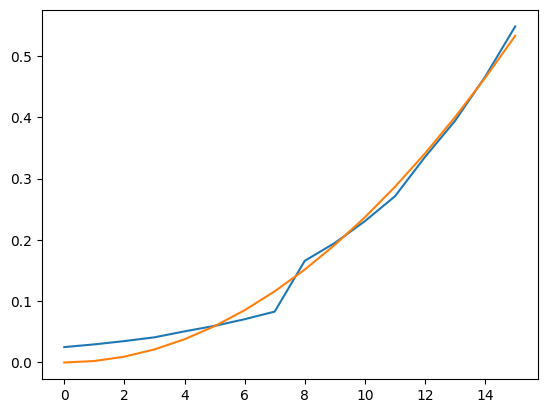

In [18]:
import matplotlib.pyplot as plt
plt.plot(approx_state)
plt.plot(state)

$f(x)=sin(x)$ \
We know that this can be loaded with a 100% accuracy for bond dimension=2

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

def sinus_state(d,qubits):
    dim = d**qubits
    state = [0]
    norm = 0
    for i in range(1,dim):
        element = np.sin(np.pi*2*i/(dim-1))
        state.append(element)
        norm += np.abs(element)**2
    norm = np.sqrt(norm)
    return np.array([i/norm for i in state])

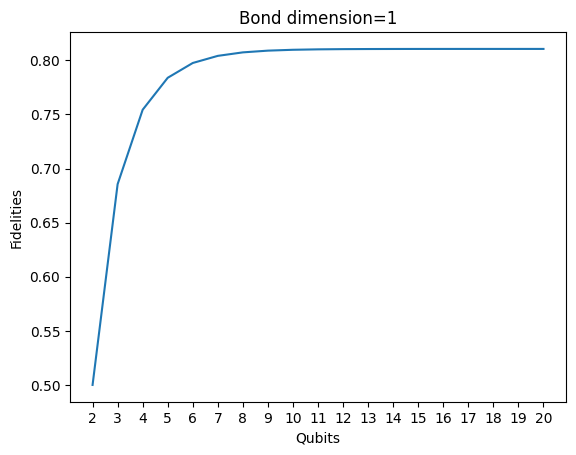

In [20]:
# FIDELITY FOR THE SINUS STATE FOR BOND DIMENSION=1

qubits = [j for j in range(2,21)]; d = 2; chi = 1
fidelities = []
for L in qubits:
    state = sinus_state(d, L)
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fidelity = np.abs(state @ approx_state)**2
    fidelities.append(fidelity)

plt.plot(qubits, fidelities)
plt.xlabel('Qubits')
plt.ylabel('Fidelities')
plt.title('Bond dimension=1')
plt.xticks(range(2, 21, 1))

plt.show()

Fidelity= [1.]


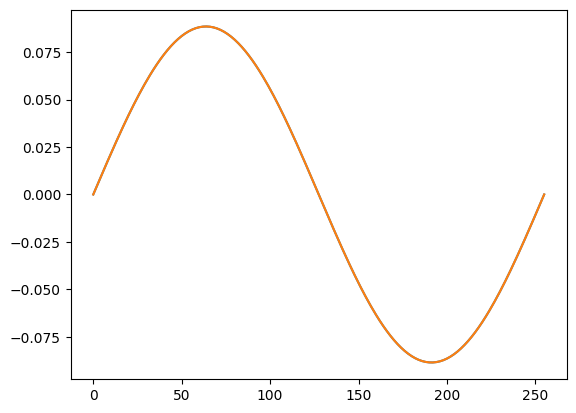

In [21]:
# PARTICULAR CASE FOR 8 QUBITS
# Here the MPS gets stucked 

L = 8; d = 2; chi = 2
state = sinus_state(d, L)
mps = MPS(state, L, d, chi)
approx_state = MPS_contraction(mps, L, d)
fidelity = np.abs(state @ approx_state)**2
print('Fidelity=',fidelity)

import matplotlib.pyplot as plt
plt.plot(approx_state)
plt.plot(state)

### Angles vs k (position in the mps)

For N=4,5,6,7,8 qubits, the angle to load the linear state at each MPS of bound dimension 1

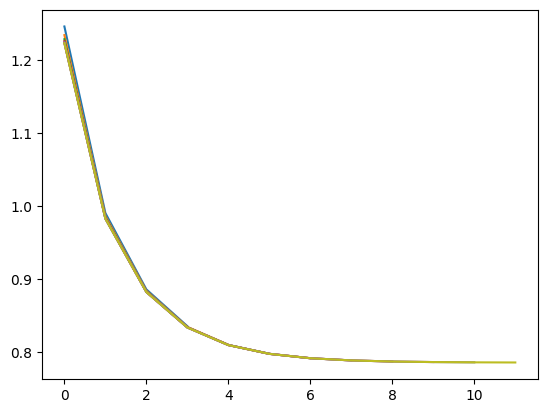

In [22]:
d = 2; chi = 1
qubits_list=[4,5,6,7,8,9,10,11,12]
angles=[],[],[],[],[], [], [], [], []
for i,k in enumerate(qubits_list):
    state = linear_state(d,k)
    mps = MPS(state, k, d, chi) 
    approx_state = MPS_contraction(mps, k, d)
    for l in range(k):
        element = np.arccos(np.abs(mps[l][0][0][0]))
        angles[i].append(element) 

for i in range(len(qubits_list)):
    plt.plot(angles[i])

In [23]:
for i in range(len(qubits_list)):
    print(angles[i])

[1.2463897548841056, 0.9905242696369762, 0.8857864793881491, 0.8353387641403583]
[1.234534228251854, 0.9865535934957365, 0.8839267958276448, 0.834422918155581, 0.8098810662516717]
[1.2288919900398982, 0.9846237845177784, 0.8830208485882147, 0.8339765337975761, 0.80965867640223, 0.7975248496071032]
[1.2261379798793945, 0.9836726276647318, 0.88257383263016, 0.8337562232826287, 0.8095489106182061, 0.7974700150900129, 0.7914336494211689]
[1.224777251106696, 0.9832004636552629, 0.8823518090926771, 0.8336467865697497, 0.8094943841484149, 0.7974427756896011, 0.7914200326955803, 0.7884090434533939]
[1.2241008951292556, 0.9829652321445265, 0.8822411676524389, 0.8335922475347185, 0.8094672098707193, 0.797429200380864, 0.7914132465176534, 0.788405650548913, 0.7869019001725007]
[1.2237637117774218, 0.982847828606742, 0.8821859394074312, 0.8335650228035214, 0.8094536449502764, 0.7974224238140528, 0.7914098589697691, 0.7884039568668749, 0.7869010533429689, 0.7861496075215714]
[1.2235953678348337, 0.

### Norm 2 instead of fidelity as figure of merit

$L_2=\sqrt{\frac{\sum (x_i-x_i')^2}{2^N}}$

In [24]:
def norm_2(exact,approximate):
    length = len(exact)
    sum = 0
    for i in range(length):
        sum = sum + (exact[i]-approximate[i])**2
    return np.sqrt(sum/length)

$f(x)=x$

In [25]:
qubits_list = [3,4,5,6]; xis = [1,2]; d = 2; degree = 1 #LINEAR FUNCTION
for L in qubits_list:
    print('NUMBER OF QUBITS =', L)
    state = monomial_state(d, L, degree)
    for chi in xis:
        mps = MPS(state, L, d, chi)
        approx_state = MPS_contraction(mps, L, d)
        norm = norm_2(state,approx_state)
        print('Norm 2 for chi = '+str(chi)+': ', norm[0])

NUMBER OF QUBITS = 3
Norm 2 for chi = 1:  0.046344148483362
Norm 2 for chi = 2:  1.9421503246222267e-16
NUMBER OF QUBITS = 4
Norm 2 for chi = 1:  0.03042420488798255
Norm 2 for chi = 2:  9.564065654677687e-17
NUMBER OF QUBITS = 5
Norm 2 for chi = 1:  0.020624145193673435
Norm 2 for chi = 2:  1.3485938528937666e-16
NUMBER OF QUBITS = 6
Norm 2 for chi = 1:  0.014261352821037545
Norm 2 for chi = 2:  5.732686748007882e-17


$f(x)=x^2$

In [26]:
qubits_list = [3,4,5,6]; xis = [1,2,3]; d = 2; degree = 2 #LINEAR FUNCTION
for L in qubits_list:
    print('NUMBER OF QUBITS =', L)
    state = monomial_state(d, L, degree)
    for chi in xis:
        mps = MPS(state, L, d, chi)
        approx_state = MPS_contraction(mps, L, d)
        norm = norm_2(state,approx_state)
        print('Fidelity for chi = '+str(chi)+': ', norm[0])

NUMBER OF QUBITS = 3
Fidelity for chi = 1:  0.022648160493276587
Fidelity for chi = 2:  1.6653495157438603e-16
Fidelity for chi = 3:  1.6653495157438603e-16
NUMBER OF QUBITS = 4
Fidelity for chi = 1:  0.01709352864139429
Fidelity for chi = 2:  0.0008011542784134627
Fidelity for chi = 3:  1.473659059458573e-16
NUMBER OF QUBITS = 5
Fidelity for chi = 1:  0.012271289907592667
Fidelity for chi = 2:  0.0005819852208796985
Fidelity for chi = 3:  8.586457759967129e-17
NUMBER OF QUBITS = 6
Fidelity for chi = 1:  0.008712760888024848
Fidelity for chi = 2:  0.00040203114047489703
Fidelity for chi = 3:  8.693787911345886e-17


### Polynomials

Option 0: $f(x)=x+x^3$

Option 1: $f(x)=x+x^2+x^3$

Option 2: $f(x)=x+8000x^3$

Option 2: $f(x)=10x+30$

Option 4: $f(x)=8000x+x^3$

Option 5: $f(x)=(x-2)(x-10)(x-13)$

Option 6: $f(x)=(x-3)(x-5)(x-7)$

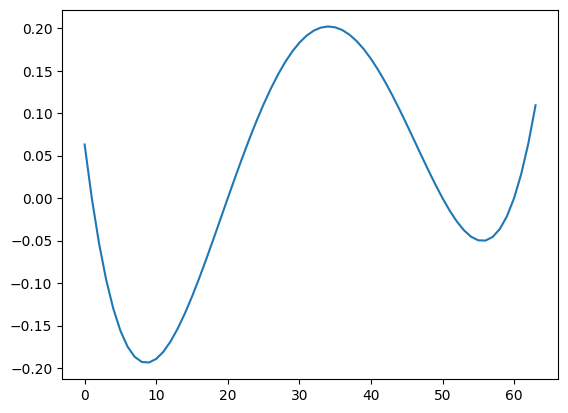

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
# Function that creates the f(x)=x state in amplitudes
# For qubits d=2
def polinomial_state(d,qubits,option):
    dim = d**qubits
    state = []
    norm = 0
    for i in range(dim):
        if option==0:
            element = 200*i+i**3
        if option==1:
            element = i+i**2+i**3
        if option==2:
            element = i+8000*i**3
        if option==3:
            element = 10*i+80
        if option==4:
            element = 8000*i+i**3
        if option==5:
            element = (i-2)*(i-10)*(i-12)
        if option==6:
            element = (i-1)*(i-20)*(i-50)*(i-60)
        if option==7:
            element = -1+i**2
        if option==8:
            element = 1/(1+np.exp(-(i-8)))
        state.append(element)
        norm += np.abs(element)**2
    norm = np.sqrt(norm)
    return np.array([i/norm for i in state])

'''''
plt.plot(polinomial_state(2,4,0))
plt.plot(polinomial_state(2,4,1))
plt.plot(polinomial_state(2,4,2))
plt.plot(polinomial_state(2,4,3))
plt.plot(polinomial_state(2,4,4))
'''''
example=6
d=2
qubits=6
plt.plot(polinomial_state(d,qubits,example))

$|\psi\rangle = \sum_i f(x_i)|i\rangle $

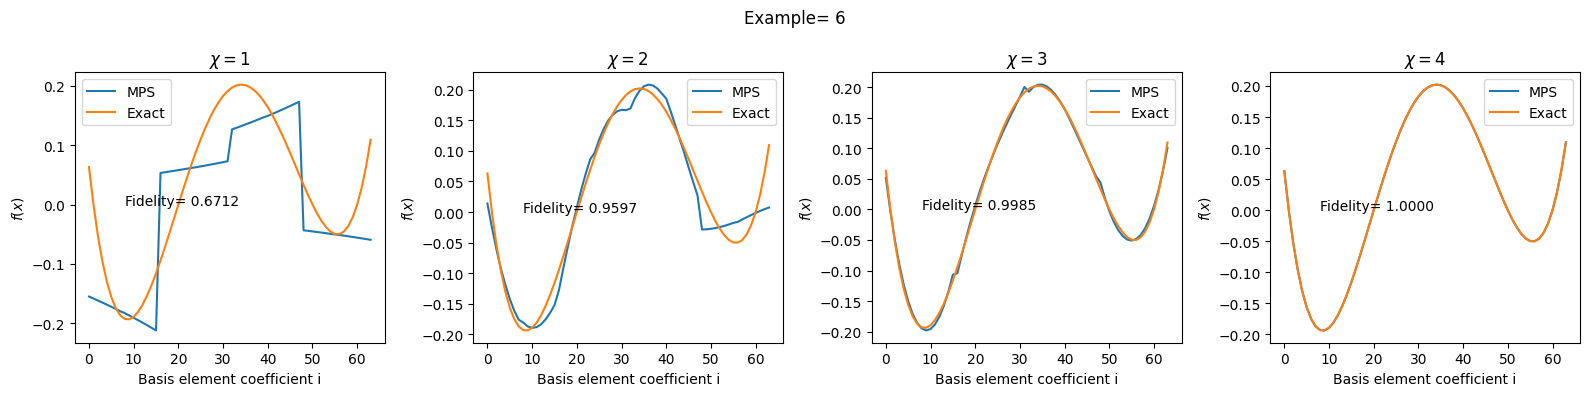

In [28]:
import matplotlib.pyplot as plt

d=2; L=6; chis=[1,2,3,4]
example=6
fidelities=[]
states=[]
state = polinomial_state(d, L, example)

for i in range(4):
    chi=chis[i]
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    states.append(approx_state.reshape(1, -1))

    fidelity = np.abs(state @ approx_state)**2
    fidelities.append(fidelity)

# Generate some dummy data for plotting
x = [j for j in range(2**L)]
y1 = states[0][0]
y2 = states[1][0]
y3 = states[2][0]
y4 = states[3][0]

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot the data and set titles and legends for each subplot
axes[0].plot(x, y1, label='MPS')
axes[0].plot(x, state, label='Exact')
axes[0].set_xlabel('Basis element coefficient i')
axes[0].set_ylabel('$f(x)$')
axes[0].set_title('$\chi=1$')
text = f'Fidelity= {fidelities[0][0]:.4f}'
axes[0].text(8, 0, text, fontsize=10, color='black')
# axes[0].set_ylim(-0.8,0.5)
axes[0].legend()

axes[1].plot(x, y2, label='MPS')
axes[1].plot(x, state, label='Exact')
axes[1].set_xlabel('Basis element coefficient i')
axes[1].set_ylabel('$f(x)$')
axes[1].set_title('$\chi=2$')
text = f'Fidelity= {fidelities[1][0]:.4f}'
axes[1].text(8,0, text, fontsize=10, color='black')
# axes[1].set_ylim(-0.8,0.5)
axes[1].legend()

axes[2].plot(x, y3, label='MPS')
axes[2].plot(x, state, label='Exact')
axes[2].set_xlabel('Basis element coefficient i')
axes[2].set_ylabel('$f(x)$')
axes[2].set_title('$\chi=3$')
text = f'Fidelity= {fidelities[2][0]:.4f}'
axes[2].text(8,0, text, fontsize=10, color='black')
# axes[2].set_ylim(-0.8,0.5)
axes[2].legend()

axes[3].plot(x, y4, label='MPS')
axes[3].plot(x, state, label='Exact')
axes[3].set_xlabel('Basis element coefficient i')
axes[3].set_ylabel('$f(x)$')
axes[3].set_title('$\chi=4$')
text = f'Fidelity= {fidelities[3][0]:.4f}'
axes[3].text(8,0, text, fontsize=10, color='black')
# axes[2].set_ylim(-0.8,0.5)
axes[3].legend()

fig.suptitle(f'Example= {example:.0f}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [29]:
print(state)
print(y1)
print(y2)
print(y3)
print(y4)

[ 0.06310024  0.         -0.05270132 -0.09579247 -0.13003697 -0.15617308
 -0.17491385 -0.18694707 -0.19293528 -0.1935158  -0.18930071 -0.18087683
 -0.16880575 -0.15362383 -0.13584219 -0.11594668 -0.09439795 -0.07163139
 -0.04805714 -0.02406012  0.          0.02378879  0.04699706  0.06934085
  0.09056146  0.11042541  0.12872448  0.14527567  0.15992124  0.17252867
  0.18299068  0.19122527  0.19717562  0.20081019  0.20212268  0.201132
  0.19788234  0.1924431   0.18490893  0.17539973  0.16406061  0.15106197
  0.13659939  0.12089374  0.10419111  0.08676282  0.06890546  0.05094082
  0.03321596  0.01610318  0.         -0.0146708  -0.02746122 -0.037898
 -0.04548265 -0.04969144 -0.04997539 -0.04576029 -0.0364467  -0.02140991
  0.          0.02845821  0.06466512  0.1093464 ]
[-0.15518911 -0.15849285 -0.16187217 -0.16531818 -0.168875   -0.17247009
 -0.17614744 -0.17989735 -0.18314591 -0.1870448  -0.1910329  -0.1950997
 -0.19929727 -0.20354    -0.20787981 -0.21230525  0.05329049  0.05442496
  0.05

### Monomials vs bound dimension

$x^2, x^3, x^4, x^7$ for 4 qubits and $\chi=1,2,3,4$

In [30]:


degrees = [2,3,4,7]
d=2
L=4

chi = 1
print('Chi=',chi)

for degree in degrees:
    state = monomial_state(d, L, degree)
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fidelity = np.abs(state @ approx_state)**2
    print('Degree = '+str(degree), fidelity)


chi = 2
print('Chi=',chi)

for degree in degrees:
    state = monomial_state(d, L, degree)
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fidelity = np.abs(state @ approx_state)**2
    print('Degree = '+str(degree), fidelity)


chi = 3
print('Chi=',chi)

for degree in degrees:
    state = monomial_state(d, L, degree)
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fidelity = np.abs(state @ approx_state)**2
    print('Degree = '+str(degree), fidelity)


chi = 4
print('Chi=',chi)

for degree in degrees:
    state = monomial_state(d, L, degree)
    mps = MPS(state, L, d, chi)
    approx_state = MPS_contraction(mps, L, d)
    fidelity = np.abs(state @ approx_state)**2
    print('Degree = '+str(degree), fidelity)

Chi= 1
Degree = 2 [0.99533044]
Degree = 3 [0.99820588]
Degree = 4 [0.99898141]
Degree = 7 [0.99967706]
Chi= 2
Degree = 2 [0.99998973]
Degree = 3 [0.99999744]
Degree = 4 [0.99999882]
Degree = 7 [0.99999995]
Chi= 3
Degree = 2 [1.]
Degree = 3 [0.99999999]
Degree = 4 [1.]
Degree = 7 [1.]
Chi= 4
Degree = 2 [1.]
Degree = 3 [1.]
Degree = 4 [1.]
Degree = 7 [1.]
